# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [59]:
import numpy as np
import os
import datetime
import abc
import cv2
import time
import matplotlib.pyplot as plt
from sys import getsizeof
import warnings
warnings.filterwarnings("ignore")

We set the random seed so that the results don't vary drastically.

In [46]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
from tensorflow import random
random.set_seed(30)

In [47]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

ModuleNotFoundError: No module named 'google.colab'

In [48]:
project_folder='storage'

### Plotting

In [49]:
# function to plot the training/validation accuracies/losses.

def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [61]:
class ModelBuilder(metaclass= abc.ABCMeta):
    # initialisng the path where project data resides
    def initialize_path(self, project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    # initialising the image properties    
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
        
    # initialising the batch size, frames to sample and the no. of epochs
    def initialize_hyperparams(self, frames_to_sample=30, batch_size=20, num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
    def generator(self,source_path, folder_list, augment=False):
        print("total frames : {}".format(self.total_frames))
        startGen = time.time()
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size = self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                start = time.time()
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 
                end = time.time()
                print(f"batch Time taken: {(end-start):.03f}s")

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels
        endGen = time.time()
        print(f"Generator Time taken: {(endGen-startGen):.03f}s")

    def one_batch_data(self,source_path, t, batch, batch_size, img_idx,augment, remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height, self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            
            for idx,item in enumerate(img_idx):
                #performing image reading and resizing
                image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                
                image_resized= cv2.resize(image, (self.image_height, self.image_width), interpolation = cv2.INTER_NEAREST)
            
                #normalizing the images
                batch_data[folder, idx, :, :, 0] = (image_resized[:,:,0])/255
                batch_data[folder, idx, :, :, 1] = (image_resized[:,:,1])/255
                batch_data[folder, idx, :, :, 2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    # cropping the images to have the targeted gestures and remove the noise from the images.
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized = cv2.resize(cropped, (self.image_height, self.image_width), interpolation = cv2.INTER_NEAREST)
                    
                    #shifted = cv2.warpAffine(image_resized, 
                    #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]), 
                    #                        (image_resized.shape[1], image_resized.shape[0]))
            
                    batch_data_aug[folder, idx, :, :, 0] = (image_resized[:,:,0])/255
                    batch_data_aug[folder, idx, :, :, 1] = (image_resized[:,:,1])/255
                    batch_data_aug[folder, idx, :, :, 2] = (image_resized[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
        
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc, augment = augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)
        
        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
   
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        
        earlystop = EarlyStopping( monitor="val_loss", min_delta=0, patience=10, verbose=1)
        callbacks_list = [checkpoint, LR, earlystop]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

    
    @abc.abstractmethod
    def define_model(self):
        pass

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [51]:
# curr_dt_time = datetime.datetime.now()
# train_path = '/notebooks/storage/Final_data/Collated_training/train'
# val_path = '/notebooks/storage/Final_data/Collated_training/val'
# num_train_sequences = len(train_doc)
# print('# training sequences =', num_train_sequences)
# num_val_sequences = len(val_doc)
# print('# validation sequences =', num_val_sequences)
# num_epochs = 10# choose the number of epochs
# print ('# epochs =', num_epochs)

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [52]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers import Conv2D, Conv3D, MaxPooling3D, MaxPooling2D, LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from keras.layers import Dropout



### Sample Model

In [62]:
class ModelConv3D(ModelBuilder):
    
    def define_model(self):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [63]:
conv_3d1=ModelConv3D()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=10,num_epochs=1)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_67 (Conv3D)          (None, 30, 160, 160, 16   1312      
                             )                                   
                                                                 
 activation_67 (Activation)  (None, 30, 160, 160, 16   0         
                             )                                   
                                                                 
 batch_normalization_89 (Ba  (None, 30, 160, 160, 16   64        
 tchNormalization)           )                                   
                                                                 
 max_pooling3d_67 (MaxPooli  (None, 15, 80, 80, 16)    0         
 ng3D)                                                           
                                                                 
 conv3d_68 (Conv3D)          (None, 15, 80, 80, 32)  

### Sample Cropping

In [64]:
test_generator = ModelConv3D()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=160,image_width=160)
test_generator.initialize_hyperparams(frames_to_sample=30,batch_size=3,num_epochs=1)

total frames : 30


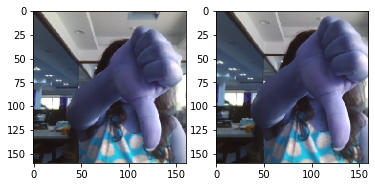

In [65]:
g = test_generator.generator(test_generator.val_path, test_generator.val_doc, augment=True)
batch_data, batch_labels=next(g)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data[0,15,:,:,:])   
axes[1].imshow(batch_data[3,15,:,:,:])   

### Experimenting with Image resolution, number of frames to use and batch_size

In [25]:
conv_3d1.train_model(conv_3d1_model)

total frames : 30


2024-03-03 22:00:06.654451: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-03-03 22:00:07.124463: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-03 22:00:09.206777: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-03 22:00:10.827659: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f20b944a550 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-03 22:00:10.827714: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2024-03-03 22:00:10.855978: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1709483410.982145   12578 device_compiler.

ResourceExhaustedError: Graph execution error:

Detected at node gradient_tape/sequential_1/max_pooling3d_4/MaxPool3D/MaxPool3DGrad defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/lib/python3/dist-packages/ipykernel_launcher.py", line 16, in <module>

  File "/usr/lib/python3/dist-packages/traitlets/config/application.py", line 846, in launch_instance

  File "/usr/lib/python3/dist-packages/ipykernel/kernelapp.py", line 677, in start

  File "/usr/lib/python3/dist-packages/tornado/platform/asyncio.py", line 199, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/lib/python3/dist-packages/ipykernel/kernelbase.py", line 461, in dispatch_queue

  File "/usr/lib/python3/dist-packages/ipykernel/kernelbase.py", line 450, in process_one

  File "/usr/lib/python3/dist-packages/ipykernel/kernelbase.py", line 357, in dispatch_shell

  File "/usr/lib/python3/dist-packages/ipykernel/kernelbase.py", line 652, in execute_request

  File "/usr/lib/python3/dist-packages/ipykernel/ipkernel.py", line 353, in do_execute

  File "/usr/lib/python3/dist-packages/ipykernel/zmqshell.py", line 532, in run_cell

  File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 2914, in run_cell

  File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 2960, in _run_cell

  File "/usr/lib/python3/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 3185, in run_cell_async

  File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 3377, in run_ast_nodes

  File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 3457, in run_code

  File "/tmp/ipykernel_12514/1646665663.py", line 1, in <module>

  File "/tmp/ipykernel_12514/3161693013.py", line 128, in train_model

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 2913, in fit_generator

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1807, in fit

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1154, in train_step

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/optimizers/optimizer.py", line 543, in minimize

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/optimizers/optimizer.py", line 276, in compute_gradients

OOM when allocating tensor with shape[10,16,30,160,160] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/sequential_1/max_pooling3d_4/MaxPool3D/MaxPool3DGrad}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_3936]

### We had hit the limit on memory resources with image resolution of 160x160 with 30 frames and batch_size of 40...we get the below error

 RESOURCE_EXHAUSTED: OOM when allocating tensor with shape[10,16,30,160,160] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc

In [26]:
print("Memory util is {} Gigs". format(getsizeof(np.zeros((40,16,30,160,160)))/(1024*1024*1024)))

Memory util is 3.662109538912773 Gigs


#### So lets trade-off between these parameters

#### Below are the experiments to see how training time is affected by image resolution, number of images in sequence and batch size

In [40]:
conv_3d1 = ModelConv3D()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=15,batch_size=5,num_epochs=2)

conv_3d1_model= conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

ValueError: Exception encountered when calling layer "max_pooling3d_46" (type MaxPooling3D).

Negative dimension size caused by subtracting 2 from 1 for '{{node max_pooling3d_46/MaxPool3D}} = MaxPool3D[T=DT_FLOAT, data_format="NDHWC", ksize=[1, 2, 2, 2, 1], padding="VALID", strides=[1, 2, 2, 2, 1]](Placeholder)' with input shapes: [?,1,12,12,128].

Call arguments received by layer "max_pooling3d_46" (type MaxPooling3D):
  • inputs=tf.Tensor(shape=(None, 1, 12, 12, 128), dtype=float32)

In [66]:
conv_3d1 = ModelConv3D()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=20,num_epochs=2)
conv_3d1_model = conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
total frames : 30
Epoch 1/2
batch Time taken: 9.770s
batch Time taken: 7.161s


2024-03-04 09:11:55.549964: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 366.21MiB (rounded to 384000000)requested by op gradient_tape/sequential_18/max_pooling3d_71/MaxPool3D/MaxPool3DGrad
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-03-04 09:11:55.550094: I external/local_tsl/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2024-03-04 09:11:55.550133: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 479, Chunks in use: 476. 119.8KiB allocated for chunks. 119.0KiB in use in bin. 61.5KiB client-requested in use in bin.
2024-03-04 09:11:55.550143: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 178, Chunks in use: 176. 90.0KiB allocated for chunks. 88.8KiB in use i

ResourceExhaustedError: Graph execution error:

Detected at node gradient_tape/sequential_18/max_pooling3d_71/MaxPool3D/MaxPool3DGrad defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/lib/python3/dist-packages/ipykernel_launcher.py", line 16, in <module>

  File "/usr/lib/python3/dist-packages/traitlets/config/application.py", line 846, in launch_instance

  File "/usr/lib/python3/dist-packages/ipykernel/kernelapp.py", line 677, in start

  File "/usr/lib/python3/dist-packages/tornado/platform/asyncio.py", line 199, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/lib/python3/dist-packages/ipykernel/kernelbase.py", line 461, in dispatch_queue

  File "/usr/lib/python3/dist-packages/ipykernel/kernelbase.py", line 450, in process_one

  File "/usr/lib/python3/dist-packages/ipykernel/kernelbase.py", line 357, in dispatch_shell

  File "/usr/lib/python3/dist-packages/ipykernel/kernelbase.py", line 652, in execute_request

  File "/usr/lib/python3/dist-packages/ipykernel/ipkernel.py", line 353, in do_execute

  File "/usr/lib/python3/dist-packages/ipykernel/zmqshell.py", line 532, in run_cell

  File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 2914, in run_cell

  File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 2960, in _run_cell

  File "/usr/lib/python3/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 3185, in run_cell_async

  File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 3377, in run_ast_nodes

  File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 3457, in run_code

  File "/tmp/ipykernel_12514/1771368839.py", line 7, in <module>

  File "/tmp/ipykernel_12514/1254015026.py", line 134, in train_model

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 2913, in fit_generator

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1807, in fit

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1154, in train_step

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/optimizers/optimizer.py", line 543, in minimize

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/optimizers/optimizer.py", line 276, in compute_gradients

OOM when allocating tensor with shape[20,16,30,100,100] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/sequential_18/max_pooling3d_71/MaxPool3D/MaxPool3DGrad}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_33933]

5.551274: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] Free  at 6040dad00 of size 23808 next 188
2024-03-04 09:11:55.551276: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 6040e0a00 of size 262144 next 225
2024-03-04 09:11:55.551278: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 604120a00 of size 262144 next 224
2024-03-04 09:11:55.551280: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 604160a00 of size 2359296 next 237
2024-03-04 09:11:55.551283: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 6043a0a00 of size 2490368 next 96
2024-03-04 09:11:55.551285: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 604600a00 of size 6553600 next 95
2024-03-04 09:11:55.551287: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 604c40a00 of size 6553600 next 139
2024-03-04 09:11:55.551289: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 605280a00 of size 2

2024-03-04 09:11:55.553063: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 60570eb00 of size 256 next 600
2024-03-04 09:11:55.553065: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] Free  at 60570ec00 of size 3328 next 607
2024-03-04 09:11:55.553067: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 60570f900 of size 512 next 276
2024-03-04 09:11:55.553069: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 60570fb00 of size 512 next 435
2024-03-04 09:11:55.553071: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 60570fd00 of size 512 next 598
2024-03-04 09:11:55.553073: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 60570ff00 of size 512 next 606
2024-03-04 09:11:55.553075: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 605710100 of size 256 next 844
2024-03-04 09:11:55.553077: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 605710200 of size 256 

In [43]:
conv_3d1=ModelConv3D()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=15,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
total frames : 30
Epoch 1/2


2024-03-03 22:15:28.803520: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 703.12MiB (rounded to 737280000)requested by op sequential_14/batch_normalization_71/FusedBatchNormV3-0-0-TransposeNCDHWToNDHWC-LayoutOptimizer
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-03-03 22:15:28.803582: I external/local_tsl/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2024-03-03 22:15:28.803592: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 468, Chunks in use: 468. 117.0KiB allocated for chunks. 117.0KiB in use in bin. 56.4KiB client-requested in use in bin.
2024-03-03 22:15:28.803596: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 160, Chunks in use: 160. 80.5KiB allocated f

ResourceExhaustedError: Graph execution error:

Detected at node sequential_14/batch_normalization_71/FusedBatchNormV3-0-0-TransposeNCDHWToNDHWC-LayoutOptimizer defined at (most recent call last):
<stack traces unavailable>
OOM when allocating tensor with shape[15,30,160,160,16] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sequential_14/batch_normalization_71/FusedBatchNormV3-0-0-TransposeNCDHWToNDHWC-LayoutOptimizer}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_29110]

tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 603988200 of size 256 next 480
2024-03-03 22:15:28.804530: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 603988300 of size 256 next 477
2024-03-03 22:15:28.804532: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 603988400 of size 256 next 470
2024-03-03 22:15:28.804534: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 603988500 of size 256 next 608
2024-03-03 22:15:28.804536: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 603988600 of size 256 next 571
2024-03-03 22:15:28.804538: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 603988700 of size 256 next 422
2024-03-03 22:15:28.804540: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 603988800 of size 256 next 604
2024-03-03 22:15:28.804542: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 603988900 of size 256 next 355
2024-03-03 22:15:28.804544: I externa

2024-03-03 22:15:28.804713: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 604084a00 of size 32768 next 308
2024-03-03 22:15:28.804718: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 60408ca00 of size 16384 next 723
2024-03-03 22:15:28.804721: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 604090a00 of size 16384 next 260
2024-03-03 22:15:28.804723: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 604094a00 of size 32768 next 261
2024-03-03 22:15:28.804725: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 60409ca00 of size 65536 next 555
2024-03-03 22:15:28.804726: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 6040aca00 of size 65536 next 550
2024-03-03 22:15:28.804729: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 6040bca00 of size 65536 next 729
2024-03-03 22:15:28.804731: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 6040cca00

2024-03-03 22:15:28.804870: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 60570ab00 of size 1280 next 541
2024-03-03 22:15:28.804872: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 60570b000 of size 256 next 542
2024-03-03 22:15:28.804874: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 60570b100 of size 256 next 543
2024-03-03 22:15:28.804875: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 60570b200 of size 256 next 544
2024-03-03 22:15:28.804877: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 60570b300 of size 256 next 545
2024-03-03 22:15:28.804879: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 60570b400 of size 256 next 546
2024-03-03 22:15:28.804881: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 60570b500 of size 256 next 547
2024-03-03 22:15:28.804883: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 60570b600 of size 256 

In [ ]:
conv_3d1=ModelConv3D()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

* As we see from the above experiments "image resolution" and number of frames in sequence have more impact on training time than batch_size
* We can consider the Batch Size around 15-40
* We will change the resoulution 160x160, 120x120 according the model performance

### Model 1

### Base Model - Batch Size = 40 and No. of Epochs = 15

In [22]:
class ModelConv3D1(ModelBuilder):
    
    def define_model(self, filtersize = (3,3,3), dense_neurons=64, dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [23]:
conv_3d1 = ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=20,batch_size=40,num_epochs=15)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 20, 160, 160, 16   1312      
                             )                                   
                                                                 
 activation_12 (Activation)  (None, 20, 160, 160, 16   0         
                             )                                   
                                                                 
 batch_normalization_16 (Ba  (None, 20, 160, 160, 16   64        
 tchNormalization)           )                                   
                                                                 
 max_pooling3d_12 (MaxPooli  (None, 10, 80, 80, 16)    0         
 ng3D)                                                           
                                                                 
 conv3d_13 (Conv3D)          (None, 10, 80, 80, 32)   

In [24]:
print("Total Params:", conv_3d1_model.count_params())
history_model1 = conv_3d1.train_model(conv_3d1_model)

Total Params: 1117061
Epoch 1/15


2024-03-03 14:47:44.764824: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.24GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-03-03 14:47:44.764869: W tensorflow/core/kernels/gpu_utils.cc:54] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.
2024-03-03 14:47:58.483839: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.22GiB (rounded to 1310720000)requested by op sequential_3/batch_normalization_16/FusedBatchNormV3
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary 

ResourceExhaustedError: Graph execution error:

Detected at node sequential_3/batch_normalization_16/FusedBatchNormV3 defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/lib/python3/dist-packages/ipykernel_launcher.py", line 16, in <module>

  File "/usr/lib/python3/dist-packages/traitlets/config/application.py", line 846, in launch_instance

  File "/usr/lib/python3/dist-packages/ipykernel/kernelapp.py", line 677, in start

  File "/usr/lib/python3/dist-packages/tornado/platform/asyncio.py", line 199, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/lib/python3/dist-packages/ipykernel/kernelbase.py", line 461, in dispatch_queue

  File "/usr/lib/python3/dist-packages/ipykernel/kernelbase.py", line 450, in process_one

  File "/usr/lib/python3/dist-packages/ipykernel/kernelbase.py", line 357, in dispatch_shell

  File "/usr/lib/python3/dist-packages/ipykernel/kernelbase.py", line 652, in execute_request

  File "/usr/lib/python3/dist-packages/ipykernel/ipkernel.py", line 353, in do_execute

  File "/usr/lib/python3/dist-packages/ipykernel/zmqshell.py", line 532, in run_cell

  File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 2914, in run_cell

  File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 2960, in _run_cell

  File "/usr/lib/python3/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 3185, in run_cell_async

  File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 3377, in run_ast_nodes

  File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 3457, in run_code

  File "/tmp/ipykernel_7997/1974171614.py", line 2, in <module>

  File "/tmp/ipykernel_7997/2689760912.py", line 127, in train_model

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 2913, in fit_generator

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1807, in fit

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1150, in train_step

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 590, in __call__

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/sequential.py", line 398, in call

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/functional.py", line 515, in call

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/layers/normalization/batch_normalization.py", line 597, in call

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/layers/normalization/batch_normalization.py", line 990, in _fused_batch_norm

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/utils/control_flow_util.py", line 108, in smart_cond

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/layers/normalization/batch_normalization.py", line 964, in _fused_batch_norm_training

OOM when allocating tensor with shape[40,16,20,25600] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sequential_3/batch_normalization_16/FusedBatchNormV3}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_7592]

nal/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 602c01100 of size 256 next 68
2024-03-03 14:47:58.484006: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 602c01200 of size 256 next 67
2024-03-03 14:47:58.484008: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 602c01300 of size 256 next 76
2024-03-03 14:47:58.484010: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 602c01400 of size 256 next 19
2024-03-03 14:47:58.484012: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 602c01500 of size 256 next 22
2024-03-03 14:47:58.484014: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 602c01600 of size 256 next 23
2024-03-03 14:47:58.484016: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 602c01700 of size 256 next 24
2024-03-03 14:47:58.484018: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 602c01800 of size 1280 next 31
2024-03-03 14:47:58.484020: I exte

In [ ]:
plot(history_model1)

next 111
2024-03-03 14:47:58.484146: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 602c0c400 of size 512 next 112
2024-03-03 14:47:58.484149: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 602c0c600 of size 512 next 113
2024-03-03 14:47:58.484151: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 602c0c800 of size 512 next 20
2024-03-03 14:47:58.484155: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] Free  at 602c0ca00 of size 32768 next 77
2024-03-03 14:47:58.484158: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 602c14a00 of size 5376 next 141
2024-03-03 14:47:58.484160: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 602c15f00 of size 5376 next 142
2024-03-03 14:47:58.484161: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 602c17400 of size 256 next 149
2024-03-03 14:47:58.484163: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 602c17500 of

#### Model is clearly overfitting. :(

### Model 2

##### Adding dropout layers - Batch Size = 20 and No. of Epochs = 25

In [25]:
conv_3d2 = ModelConv3D1()
conv_3d2.initialize_path(project_folder)
conv_3d2.initialize_image_properties(image_height=160,image_width=160)
conv_3d2.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=25)
conv_3d2_model= conv_3d2.define_model(dense_neurons = 256, dropout=0.5)
conv_3d2_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_16 (Conv3D)          (None, 20, 160, 160, 16   1312      
                             )                                   
                                                                 
 activation_16 (Activation)  (None, 20, 160, 160, 16   0         
                             )                                   
                                                                 
 batch_normalization_22 (Ba  (None, 20, 160, 160, 16   64        
 tchNormalization)           )                                   
                                                                 
 max_pooling3d_16 (MaxPooli  (None, 10, 80, 80, 16)    0         
 ng3D)                                                           
                                                                 
 conv3d_17 (Conv3D)          (None, 10, 80, 80, 32)   

In [26]:
print("Total Params:", conv_3d2_model.count_params())
history_model2=conv_3d2.train_model(conv_3d2_model,augment_data=True)

Total Params: 3638981
Epoch 1/25


2024-03-03 14:48:21.473508: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.22GiB (rounded to 1310720000)requested by op sequential_4/batch_normalization_22/FusedBatchNormV3
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-03-03 14:48:21.473564: I external/local_tsl/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2024-03-03 14:48:21.473585: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 228, Chunks in use: 227. 57.0KiB allocated for chunks. 56.8KiB in use in bin. 23.2KiB client-requested in use in bin.
2024-03-03 14:48:21.473589: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 45, Chunks in use: 45. 22.5KiB allocated for chunks. 22.5KiB in use in bin. 22.3KiB client

ResourceExhaustedError: Graph execution error:

Detected at node sequential_4/batch_normalization_22/FusedBatchNormV3 defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/lib/python3/dist-packages/ipykernel_launcher.py", line 16, in <module>

  File "/usr/lib/python3/dist-packages/traitlets/config/application.py", line 846, in launch_instance

  File "/usr/lib/python3/dist-packages/ipykernel/kernelapp.py", line 677, in start

  File "/usr/lib/python3/dist-packages/tornado/platform/asyncio.py", line 199, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/lib/python3/dist-packages/ipykernel/kernelbase.py", line 461, in dispatch_queue

  File "/usr/lib/python3/dist-packages/ipykernel/kernelbase.py", line 450, in process_one

  File "/usr/lib/python3/dist-packages/ipykernel/kernelbase.py", line 357, in dispatch_shell

  File "/usr/lib/python3/dist-packages/ipykernel/kernelbase.py", line 652, in execute_request

  File "/usr/lib/python3/dist-packages/ipykernel/ipkernel.py", line 353, in do_execute

  File "/usr/lib/python3/dist-packages/ipykernel/zmqshell.py", line 532, in run_cell

  File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 2914, in run_cell

  File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 2960, in _run_cell

  File "/usr/lib/python3/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 3185, in run_cell_async

  File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 3377, in run_ast_nodes

  File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 3457, in run_code

  File "/tmp/ipykernel_7997/307783883.py", line 2, in <module>

  File "/tmp/ipykernel_7997/2689760912.py", line 127, in train_model

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 2913, in fit_generator

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1807, in fit

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1150, in train_step

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 590, in __call__

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/sequential.py", line 398, in call

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/functional.py", line 515, in call

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/layers/normalization/batch_normalization.py", line 597, in call

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/layers/normalization/batch_normalization.py", line 990, in _fused_batch_norm

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/utils/control_flow_util.py", line 108, in smart_cond

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/layers/normalization/batch_normalization.py", line 964, in _fused_batch_norm_training

OOM when allocating tensor with shape[40,16,20,25600] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sequential_4/batch_normalization_22/FusedBatchNormV3}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_11014]

30
2024-03-03 14:48:21.473724: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 602c02500 of size 512 next 18
2024-03-03 14:48:21.473725: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 602c02700 of size 512 next 40
2024-03-03 14:48:21.473727: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 602c02900 of size 256 next 41
2024-03-03 14:48:21.473729: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 602c02a00 of size 256 next 42
2024-03-03 14:48:21.473731: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 602c02b00 of size 1024 next 48
2024-03-03 14:48:21.473733: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 602c02f00 of size 1024 next 34
2024-03-03 14:48:21.473736: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 602c03300 of size 1024 next 45
2024-03-03 14:48:21.473737: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 602c03700 of size 1024 n

2024-03-03 14:48:21.473933: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 602c0e900 of size 256 next 313
2024-03-03 14:48:21.473935: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 602c0ea00 of size 256 next 314
2024-03-03 14:48:21.473937: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 602c0eb00 of size 256 next 315
2024-03-03 14:48:21.473939: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 602c0ec00 of size 256 next 316
2024-03-03 14:48:21.473941: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 602c0ed00 of size 256 next 317
2024-03-03 14:48:21.473943: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 602c0ee00 of size 256 next 318
2024-03-03 14:48:21.473944: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 602c0ef00 of size 256 next 319
2024-03-03 14:48:21.473946: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 602c0f000 of size 256 n

In [34]:
plot(history_model2)

NameError: name 'history_model2' is not defined

### We can see val_loss did not improve from 1.24219 so earlystopping stops the epoch automatically!!
* Last Epoch stop on 15/25!! good job earlystopping ;)
* Best weights save automatically. The validation accuracy of 52% and training accuracy of 65%. Next we will try to reduce the filter size and image resolution and see if get better results. Moreover since we see minor oscillations in loss, let's try lowering the learning rate to 0.0002

### Model 3

##### Reduce filter size to (2,2,2) and image res to 120 x 120, - Batch Size = 30 and No. of Epochs = 25

In [35]:
class ModelConv3D3(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))
        
        optimiser = optimizers.Adam(learning_rate=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [36]:
conv_3d3=ModelConv3D3()
conv_3d3.initialize_path(project_folder)
conv_3d3.initialize_image_properties(image_height=120,image_width=120)
conv_3d3.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=25)
conv_3d3_model=conv_3d3.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv_3d3_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_24 (Conv3D)          (None, 16, 120, 120, 16   400       
                             )                                   
                                                                 
 activation_24 (Activation)  (None, 16, 120, 120, 16   0         
                             )                                   
                                                                 
 batch_normalization_34 (Ba  (None, 16, 120, 120, 16   64        
 tchNormalization)           )                                   
                                                                 
 max_pooling3d_24 (MaxPooli  (None, 8, 60, 60, 16)     0         
 ng3D)                                                           
                                                                 
 conv3d_25 (Conv3D)          (None, 8, 60, 60, 32)    

In [37]:
print("Total Params:", conv_3d3_model.count_params())
history_model3=conv_3d3.train_model(conv_3d3_model,augment_data=True)

Total Params: 1762613
Epoch 1/25


2024-03-03 14:38:22.395373: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 165889200 bytes after encountering the first element of size 165889200 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-03-03 14:38:22.479836: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 859.75MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-03-03 14:38:34.101735: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 843.75MiB (rounded to 884736000)requested by op sequential_6/batch_normalization_34/FusedBatchNormV3-0-0-TransposeNCDHWToNDHWC-LayoutOptimizer
If the cause is memory fragmentation maybe the environme

2024-03-03 14:38:34.102492: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 602c6e000 of size 512 next 372
2024-03-03 14:38:34.102494: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 602c6e200 of size 512 next 373
2024-03-03 14:38:34.102496: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 602c6e400 of size 512 next 377
2024-03-03 14:38:34.102498: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 602c6e600 of size 512 next 378
2024-03-03 14:38:34.102500: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 602c6e800 of size 256 next 379
2024-03-03 14:38:34.102502: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 602c6e900 of size 256 next 380
2024-03-03 14:38:34.102504: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 602c6ea00 of size 1024 next 383
2024-03-03 14:38:34.102507: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 602c6ee00 of size 1024

2024-03-03 14:38:34.102859: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 605fcc000 of size 256 next 461
2024-03-03 14:38:34.102861: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 605fcc100 of size 256 next 463
2024-03-03 14:38:34.102863: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 605fcc200 of size 256 next 466
2024-03-03 14:38:34.102865: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 605fcc300 of size 256 next 467
2024-03-03 14:38:34.102867: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 605fcc400 of size 256 next 464
2024-03-03 14:38:34.102869: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 605fcc500 of size 256 next 465
2024-03-03 14:38:34.102871: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 605fcc600 of size 256 next 469
2024-03-03 14:38:34.102873: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 605fcc700 of size 256 n

MaxInUse:                   2191783680
NumAllocs:                        1438
MaxAllocSize:               1310720000
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0

2024-03-03 14:38:34.145076: W external/local_tsl/tsl/framework/bfc_allocator.cc:497] ******______***********************************************************************************xxxxx
2024-03-03 14:38:34.226681: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at transpose_op.cc:184 : RESOURCE_EXHAUSTED: OOM when allocating tensor with shape[60,16,120,120,16] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc


ResourceExhaustedError: Graph execution error:

Detected at node sequential_6/batch_normalization_34/FusedBatchNormV3-0-0-TransposeNCDHWToNDHWC-LayoutOptimizer defined at (most recent call last):
<stack traces unavailable>
OOM when allocating tensor with shape[60,16,120,120,16] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sequential_6/batch_normalization_34/FusedBatchNormV3-0-0-TransposeNCDHWToNDHWC-LayoutOptimizer}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_17952]

In [ ]:
plot(history_model3)

##### Model has a best validation accuracy of 72% and training accuracy of 76% . Also we were able to reduce the parameter size by half the earlier model. Let's trying adding more layers

### Model 4 -

##### Adding more layers - Batch Size = 20 and No. of Epochs = 25

In [40]:
class ModelConv3D4(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3), dense_neurons=64, dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [42]:
conv_3d4 = ModelConv3D4()
conv_3d4.initialize_path(project_folder)
conv_3d4.initialize_image_properties(image_height=120,image_width=120)
conv_3d4.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d4_model=conv_3d4.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.5)
conv_3d4_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_28 (Conv3D)          (None, 16, 120, 120, 16   1312      
                             )                                   
                                                                 
 activation_28 (Activation)  (None, 16, 120, 120, 16   0         
                             )                                   
                                                                 
 batch_normalization_40 (Ba  (None, 16, 120, 120, 16   64        
 tchNormalization)           )                                   
                                                                 
 conv3d_29 (Conv3D)          (None, 16, 120, 120, 16   6928      
                             )                                   
                                                                 
 activation_29 (Activation)  (None, 16, 120, 120, 16  

In [43]:
print("Total Params:", conv_3d4_model.count_params())
history_model4=conv_3d4.train_model(conv_3d4_model,augment_data=True)

Total Params: 2556533
Epoch 1/25


2024-03-03 14:40:37.809824: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 110592800 bytes after encountering the first element of size 110592800 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-03-03 14:40:39.760438: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 578.50MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-03-03 14:40:56.274566: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 562.50MiB (rounded to 589824000)requested by op sequential_7/batch_normalization_41/FusedBatchNormV3
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_

ResourceExhaustedError: Graph execution error:

Detected at node sequential_7/batch_normalization_41/FusedBatchNormV3 defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/lib/python3/dist-packages/ipykernel_launcher.py", line 16, in <module>

  File "/usr/lib/python3/dist-packages/traitlets/config/application.py", line 846, in launch_instance

  File "/usr/lib/python3/dist-packages/ipykernel/kernelapp.py", line 677, in start

  File "/usr/lib/python3/dist-packages/tornado/platform/asyncio.py", line 199, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/lib/python3/dist-packages/ipykernel/kernelbase.py", line 461, in dispatch_queue

  File "/usr/lib/python3/dist-packages/ipykernel/kernelbase.py", line 450, in process_one

  File "/usr/lib/python3/dist-packages/ipykernel/kernelbase.py", line 357, in dispatch_shell

  File "/usr/lib/python3/dist-packages/ipykernel/kernelbase.py", line 652, in execute_request

  File "/usr/lib/python3/dist-packages/ipykernel/ipkernel.py", line 353, in do_execute

  File "/usr/lib/python3/dist-packages/ipykernel/zmqshell.py", line 532, in run_cell

  File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 2914, in run_cell

  File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 2960, in _run_cell

  File "/usr/lib/python3/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 3185, in run_cell_async

  File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 3377, in run_ast_nodes

  File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 3457, in run_code

  File "/tmp/ipykernel_7064/2876131184.py", line 2, in <module>

  File "/tmp/ipykernel_7064/2689760912.py", line 127, in train_model

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 2913, in fit_generator

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1807, in fit

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1150, in train_step

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 590, in __call__

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/sequential.py", line 398, in call

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/functional.py", line 515, in call

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/layers/normalization/batch_normalization.py", line 597, in call

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/layers/normalization/batch_normalization.py", line 990, in _fused_batch_norm

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/utils/control_flow_util.py", line 108, in smart_cond

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/layers/normalization/batch_normalization.py", line 964, in _fused_batch_norm_training

OOM when allocating tensor with shape[40,16,16,14400] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sequential_7/batch_normalization_41/FusedBatchNormV3}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_23050]

7600 of size 256 next 415
2024-03-03 14:40:56.275624: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 605f07700 of size 256 next 416
2024-03-03 14:40:56.275626: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 605f07800 of size 256 next 418
2024-03-03 14:40:56.275628: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 605f07900 of size 256 next 419
2024-03-03 14:40:56.275630: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 605f07a00 of size 256 next 420
2024-03-03 14:40:56.275633: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 605f07b00 of size 256 next 421
2024-03-03 14:40:56.275635: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 605f07c00 of size 256 next 422
2024-03-03 14:40:56.275637: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 605f07d00 of size 256 next 423
2024-03-03 14:40:56.275639: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse 

In [ ]:
plot(history_model4)

d1500 of size 1536 next 510
2024-03-03 14:40:56.275832: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 605fd1b00 of size 256 next 511
2024-03-03 14:40:56.275834: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 605fd1c00 of size 256 next 512
2024-03-03 14:40:56.275837: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 605fd1d00 of size 256 next 513
2024-03-03 14:40:56.275839: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 605fd1e00 of size 256 next 514
2024-03-03 14:40:56.275841: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 605fd1f00 of size 256 next 515
2024-03-03 14:40:56.275844: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 605fd2000 of size 256 next 516
2024-03-03 14:40:56.275846: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 605fd2100 of size 256 next 519
2024-03-03 14:40:56.275848: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUs

#### With more layers we dont see much performance improvement. We get a best validation accuracy of 76% . Let's try adding dropouts at the convolution layers

### Model 5
#### Adding dropout at convolution layers

In [44]:
class ModelConv3D5(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [45]:
conv_3d5=ModelConv3D5()
conv_3d5.initialize_path(project_folder)
conv_3d5.initialize_image_properties(image_height=120,image_width=120)
conv_3d5.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=15)
conv_3d5_model=conv_3d5.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.25)
conv_3d5_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_36 (Conv3D)          (None, 16, 120, 120, 16   1312      
                             )                                   
                                                                 
 activation_36 (Activation)  (None, 16, 120, 120, 16   0         
                             )                                   
                                                                 
 batch_normalization_50 (Ba  (None, 16, 120, 120, 16   64        
 tchNormalization)           )                                   
                                                                 
 conv3d_37 (Conv3D)          (None, 16, 120, 120, 16   6928      
                             )                                   
                                                                 
 activation_37 (Activation)  (None, 16, 120, 120, 16  

In [46]:
print("Total Params:", conv_3d5_model.count_params())
history_model5=conv_3d5.train_model(conv_3d5_model,augment_data=True)

Total Params: 2556533
Epoch 1/15


2024-03-03 14:41:48.896486: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 110592800 bytes after encountering the first element of size 110592800 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-03-03 14:41:58.940192: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 562.50MiB (rounded to 589824000)requested by op sequential_8/batch_normalization_51/FusedBatchNormV3
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-03-03 14:41:58.940348: I external/local_tsl/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2024-03-03 14:41:58.940387: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] B

ResourceExhaustedError: Graph execution error:

Detected at node sequential_8/batch_normalization_51/FusedBatchNormV3 defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/lib/python3/dist-packages/ipykernel_launcher.py", line 16, in <module>

  File "/usr/lib/python3/dist-packages/traitlets/config/application.py", line 846, in launch_instance

  File "/usr/lib/python3/dist-packages/ipykernel/kernelapp.py", line 677, in start

  File "/usr/lib/python3/dist-packages/tornado/platform/asyncio.py", line 199, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/lib/python3/dist-packages/ipykernel/kernelbase.py", line 461, in dispatch_queue

  File "/usr/lib/python3/dist-packages/ipykernel/kernelbase.py", line 450, in process_one

  File "/usr/lib/python3/dist-packages/ipykernel/kernelbase.py", line 357, in dispatch_shell

  File "/usr/lib/python3/dist-packages/ipykernel/kernelbase.py", line 652, in execute_request

  File "/usr/lib/python3/dist-packages/ipykernel/ipkernel.py", line 353, in do_execute

  File "/usr/lib/python3/dist-packages/ipykernel/zmqshell.py", line 532, in run_cell

  File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 2914, in run_cell

  File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 2960, in _run_cell

  File "/usr/lib/python3/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 3185, in run_cell_async

  File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 3377, in run_ast_nodes

  File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 3457, in run_code

  File "/tmp/ipykernel_7064/173256649.py", line 2, in <module>

  File "/tmp/ipykernel_7064/2689760912.py", line 127, in train_model

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 2913, in fit_generator

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1807, in fit

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1150, in train_step

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 590, in __call__

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/sequential.py", line 398, in call

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/functional.py", line 515, in call

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/layers/normalization/batch_normalization.py", line 597, in call

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/layers/normalization/batch_normalization.py", line 990, in _fused_batch_norm

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/utils/control_flow_util.py", line 108, in smart_cond

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/layers/normalization/batch_normalization.py", line 964, in _fused_batch_norm_training

OOM when allocating tensor with shape[40,16,16,14400] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sequential_8/batch_normalization_51/FusedBatchNormV3}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_28344]

tsl/framework/bfc_allocator.cc:1095] InUse at 605fd2c00 of size 256 next 531
2024-03-03 14:41:58.943917: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 605fd2d00 of size 512 next 533
2024-03-03 14:41:58.943921: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 605fd2f00 of size 512 next 534
2024-03-03 14:41:58.943926: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 605fd3100 of size 512 next 535
2024-03-03 14:41:58.943930: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 605fd3300 of size 768 next 508
2024-03-03 14:41:58.943935: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 605fd3600 of size 8448 next 474
2024-03-03 14:41:58.943940: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 605fd5700 of size 16384 next 473
2024-03-03 14:41:58.943944: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 605fd9700 of size 16384 next 517
2024-03-03 14:41:58.943949: I extern

In [48]:
plot(history_model5)

NameError: name 'history_model5' is not defined

#### Ohh! Overfitting again!! Adding dropouts has further reduced validation accuracy as the model doesn't seem to generalise well.

**All the experimental models above have more than 1 million parameters. Let's try to reduce the model size and see the performance**

## Model 6
### Reducing the number of parameters

In [3]:
class ModelConv3D6(ModelBuilder):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(learning_rate=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

NameError: name 'ModelBuilder' is not defined

In [52]:
conv_3d6=ModelConv3D6()
conv_3d6.initialize_path(project_folder)
conv_3d6.initialize_image_properties(image_height=100,image_width=100)
conv_3d6.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=20)
conv_3d6_model=conv_3d6.define_model(dense_neurons=128,dropout=0.25)
conv_3d6_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_48 (Conv3D)          (None, 16, 100, 100, 16   1312      
                             )                                   
                                                                 
 activation_48 (Activation)  (None, 16, 100, 100, 16   0         
                             )                                   
                                                                 
 batch_normalization_66 (Ba  (None, 16, 100, 100, 16   64        
 tchNormalization)           )                                   
                                                                 
 max_pooling3d_40 (MaxPooli  (None, 8, 50, 50, 16)     0         
 ng3D)                                                           
                                                                 
 conv3d_49 (Conv3D)          (None, 8, 50, 50, 32)   

In [ ]:
print("Total Params:", conv_3d6_model.count_params())
history_model6=conv_3d6.train_model(conv_3d6_model,augment_data=True)

Total Params: 696645
Epoch 1/20


2024-03-03 14:45:01.117710: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 76800800 bytes after encountering the first element of size 76800800 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


In [ ]:
plot(history_model6)

For the above low memory foot print model, we get the best validation accuracy of 74%

## Model 7 - Reducing the number of parameters again

In [30]:
class ModelConv3D7(ModelBuilder):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(learning_rate=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [31]:
conv_3d7=ModelConv3D7()
conv_3d7.initialize_path(project_folder)
conv_3d7.initialize_image_properties(image_height=120,image_width=120)
conv_3d7.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d7_model=conv_3d7.define_model(dense_neurons=64,dropout=0.25)
conv_3d7_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_24 (Conv3D)          (None, 16, 120, 120, 16   1312      
                             )                                   
                                                                 
 activation_24 (Activation)  (None, 16, 120, 120, 16   0         
                             )                                   
                                                                 
 batch_normalization_34 (Ba  (None, 16, 120, 120, 16   64        
 tchNormalization)           )                                   
                                                                 
 max_pooling3d_24 (MaxPooli  (None, 8, 60, 60, 16)     0         
 ng3D)                                                           
                                                                 
 conv3d_25 (Conv3D)          (None, 8, 60, 60, 32)    

In [32]:
print("Total Params:", conv_3d7_model.count_params())
history_model7=conv_3d7.train_model(conv_3d7_model,augment_data=True)

Total Params: 504709
Epoch 1/25


2024-03-03 15:10:55.781859: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 664.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-03-03 15:10:55.803353: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 664.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-03-03 15:10:56.032444: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 268.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-03-03 15:10:56.074735: W external/local_tsl/tsl/framewor

ResourceExhaustedError: Graph execution error:

Detected at node gradient_tape/sequential_6/max_pooling3d_25/MaxPool3D/MaxPool3DGrad defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/lib/python3/dist-packages/ipykernel_launcher.py", line 16, in <module>

  File "/usr/lib/python3/dist-packages/traitlets/config/application.py", line 846, in launch_instance

  File "/usr/lib/python3/dist-packages/ipykernel/kernelapp.py", line 677, in start

  File "/usr/lib/python3/dist-packages/tornado/platform/asyncio.py", line 199, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/lib/python3/dist-packages/ipykernel/kernelbase.py", line 461, in dispatch_queue

  File "/usr/lib/python3/dist-packages/ipykernel/kernelbase.py", line 450, in process_one

  File "/usr/lib/python3/dist-packages/ipykernel/kernelbase.py", line 357, in dispatch_shell

  File "/usr/lib/python3/dist-packages/ipykernel/kernelbase.py", line 652, in execute_request

  File "/usr/lib/python3/dist-packages/ipykernel/ipkernel.py", line 353, in do_execute

  File "/usr/lib/python3/dist-packages/ipykernel/zmqshell.py", line 532, in run_cell

  File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 2914, in run_cell

  File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 2960, in _run_cell

  File "/usr/lib/python3/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 3185, in run_cell_async

  File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 3377, in run_ast_nodes

  File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 3457, in run_code

  File "/tmp/ipykernel_7997/11128284.py", line 2, in <module>

  File "/tmp/ipykernel_7997/2689760912.py", line 127, in train_model

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 2913, in fit_generator

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1807, in fit

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1154, in train_step

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/optimizers/optimizer.py", line 543, in minimize

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/optimizers/optimizer.py", line 276, in compute_gradients

OOM when allocating tensor with shape[40,32,8,60,60] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/sequential_6/max_pooling3d_25/MaxPool3D/MaxPool3DGrad}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_14903]

work/bfc_allocator.cc:1095] InUse at 602c0c600 of size 512 next 113
2024-03-03 15:11:06.400638: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 602c0c800 of size 512 next 20
2024-03-03 15:11:06.400648: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 602c0ca00 of size 5376 next 78
2024-03-03 15:11:06.400656: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 602c0df00 of size 256 next 301
2024-03-03 15:11:06.400665: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 602c0e000 of size 256 next 300
2024-03-03 15:11:06.400673: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 602c0e100 of size 256 next 302
2024-03-03 15:11:06.400682: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 602c0e200 of size 256 next 306
2024-03-03 15:11:06.400690: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 602c0e300 of size 256 next 307
2024-03-03 15:11:06.400698: I external/local_tsl/ts

In [33]:
plot(history_model7)

NameError: name 'history_model7' is not defined

For the above low memory foot print model the best validation accuracy of 73%

## Model 8 - CNN- LSTM Model

In [40]:
class RNNCNN1(ModelBuilder):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        #model.add(TimeDistributed(Conv2D(512, (2, 2) , padding='valid', activation='relu')))
       # model.add(TimeDistributed(BatchNormalization()))
       # model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))


        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [41]:
rnn_cnn1=RNNCNN1()
rnn_cnn1.initialize_path(project_folder)
rnn_cnn1.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn1.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
rnn_cnn1_model=rnn_cnn1.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn1_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_16 (TimeD  (None, 18, 120, 120, 16   448       
 istributed)                 )                                   
                                                                 
 time_distributed_17 (TimeD  (None, 18, 120, 120, 16   64        
 istributed)                 )                                   
                                                                 
 time_distributed_18 (TimeD  (None, 18, 60, 60, 16)    0         
 istributed)                                                     
                                                                 
 time_distributed_19 (TimeD  (None, 18, 60, 60, 32)    4640      
 istributed)                                                     
                                                                 
 time_distributed_20 (TimeD  (None, 18, 60, 60, 32)   

In [42]:
print("Total Params:", rnn_cnn1_model.count_params())
history_model8=rnn_cnn1.train_model(rnn_cnn1_model,augment_data=True)

Total Params: 1657445
Epoch 1/20


2024-03-03 15:13:20.855236: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.06GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-03-03 15:13:20.979326: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.67GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-03-03 15:13:21.240086: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.44GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-03-03 15:13:21.389168: W external/local_tsl/tsl/framework/bfc_

ResourceExhaustedError: Graph execution error:

Detected at node sequential_8/time_distributed_17/batch_normalization_45/FusedBatchNormV3-0-1-TransposeNCHWToNHWC-LayoutOptimizer defined at (most recent call last):
<stack traces unavailable>
OOM when allocating tensor with shape[720,120,120,16] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sequential_8/time_distributed_17/batch_normalization_45/FusedBatchNormV3-0-1-TransposeNCHWToNHWC-LayoutOptimizer}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_22381]

095] InUse at 602c21600 of size 1024 next 342
2024-03-03 15:13:31.752026: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 602c21a00 of size 5120 next 343
2024-03-03 15:13:31.752032: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 602c22e00 of size 5120 next 344
2024-03-03 15:13:31.752037: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 602c24200 of size 256 next 345
2024-03-03 15:13:31.752044: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 602c24300 of size 256 next 346
2024-03-03 15:13:31.752050: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 602c24400 of size 256 next 347
2024-03-03 15:13:31.752056: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 602c24500 of size 256 next 348
2024-03-03 15:13:31.752061: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 602c24600 of size 256 next 349
2024-03-03 15:13:31.752067: I external/local_tsl/tsl/framework/bfc_all

2024-03-03 15:13:31.752355: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 602c5c800 of size 256 next 217
2024-03-03 15:13:31.752357: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 602c5c900 of size 256 next 216
2024-03-03 15:13:31.752359: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 602c5ca00 of size 256 next 223
2024-03-03 15:13:31.752361: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 602c5cb00 of size 512 next 116
2024-03-03 15:13:31.752363: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 602c5cd00 of size 512 next 226
2024-03-03 15:13:31.752365: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 602c5cf00 of size 512 next 222
2024-03-03 15:13:31.752367: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 602c5d100 of size 512 next 225
2024-03-03 15:13:31.752369: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 602c5d300 of size 512 n

2024-03-03 15:13:31.752678: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 603d26000 of size 256 next 493
2024-03-03 15:13:31.752680: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 603d26100 of size 256 next 494
2024-03-03 15:13:31.752682: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 603d26200 of size 256 next 495
2024-03-03 15:13:31.752684: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 603d26300 of size 256 next 496
2024-03-03 15:13:31.752686: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 603d26400 of size 256 next 497
2024-03-03 15:13:31.752688: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 603d26500 of size 256 next 498
2024-03-03 15:13:31.752691: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 603d26600 of size 256 next 499
2024-03-03 15:13:31.752692: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 603d26700 of size 256 n

In [ ]:
plot(history_model8)

### For CNN - LSTM model we get a best validation accuracy of 85%
As we see more cases of overfitting, lets augment the data with ***slight rotation*** as well and run the same set of models again

## Let's apply some data augmentation & check the model performance.

In [10]:
class ModelBuilderMoreAugmentation(metaclass= abc.ABCMeta):
    
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
          
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx): 
                image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized= cv2.resize(image,(self.image_height,self.image_width), interpolation = cv2.INTER_AREA)
            

                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized= cv2.resize(cropped,(self.image_height,self.image_width), interpolation = cv2.INTER_AREA)
                    
                    M = cv2.getRotationMatrix2D((self.image_width//2,self.image_height//2),
                                                np.random.randint(-10,10), 1.0)
                    rotated = cv2.warpAffine(image_resized, M, (self.image_width, self.image_height))
                    
                    #shifted = cv2.warpAffine(image_resized, 
                    #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]), 
                    #                        (image_resized.shape[1], image_resized.shape[0]))
            
                    batch_data_aug[folder,idx,:,:,0] = (rotated[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (rotated[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (rotated[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


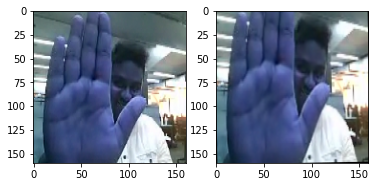

In [11]:
class Test(ModelBuilderMoreAugmentation):
    def define_model(self):
        pass

test_generator=Test()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=160,image_width=160)
test_generator.initialize_hyperparams(frames_to_sample=30,batch_size=3,num_epochs=1)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=True)
batch_data, batch_labels=next(g)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data[0,29,:,:,:])   
axes[1].imshow(batch_data[3,29,:,:,:])   

## Model 9 with Augmentation
### (3,3,3) Filter & 160x160 Image resolution - similar to Model 2

In [12]:
class ModelConv3D9(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(learning_rate=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [13]:
conv_3d9=ModelConv3D9()
conv_3d9.initialize_path(project_folder)
conv_3d9.initialize_image_properties(image_height=160,image_width=160)
conv_3d9.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=20)
conv_3d9_model=conv_3d9.define_model(dense_neurons=256,dropout=0.5)
conv_3d9_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 20, 160, 160, 16   1312      
                             )                                   
                                                                 
 activation (Activation)     (None, 20, 160, 160, 16   0         
                             )                                   
                                                                 
 batch_normalization (Batch  (None, 20, 160, 160, 16   64        
 Normalization)              )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 10, 80, 80, 16)    0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 10, 80, 80, 32)    1

2024-03-03 15:20:57.128617: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-03 15:20:57.477308: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-03 15:20:57.477352: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-03 15:20:57.479887: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-03 15:20:57.479931: I external/local_xla/xla/stream_executor

 chNormalization)                                                
                                                                 
 max_pooling3d_1 (MaxPoolin  (None, 5, 40, 40, 32)     0         
 g3D)                                                            
                                                                 
 conv3d_2 (Conv3D)           (None, 5, 40, 40, 64)     55360     
                                                                 
 activation_2 (Activation)   (None, 5, 40, 40, 64)     0         
                                                                 
 batch_normalization_2 (Bat  (None, 5, 40, 40, 64)     256       
 chNormalization)                                                
                                                                 
 max_pooling3d_2 (MaxPoolin  (None, 2, 20, 20, 64)     0         
 g3D)                                                            
                                                                 
 conv3d_3 

In [14]:
print("Total Params:", conv_3d9_model.count_params())
history_model9=conv_3d9.train_model(conv_3d9_model,augment_data=True)

Total Params: 3638981
Epoch 1/20


2024-03-03 15:21:06.064643: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.24GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-03-03 15:21:06.064700: W tensorflow/core/kernels/gpu_utils.cc:54] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.
2024-03-03 15:21:06.122952: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-03-03 15:21:06.694908: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-03 15:21:06.697529: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: Not a directory


ResourceExhaustedError: Graph execution error:

Detected at node sequential/batch_normalization/FusedBatchNormV3 defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/lib/python3/dist-packages/ipykernel_launcher.py", line 16, in <module>

  File "/usr/lib/python3/dist-packages/traitlets/config/application.py", line 846, in launch_instance

  File "/usr/lib/python3/dist-packages/ipykernel/kernelapp.py", line 677, in start

  File "/usr/lib/python3/dist-packages/tornado/platform/asyncio.py", line 199, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/lib/python3/dist-packages/ipykernel/kernelbase.py", line 461, in dispatch_queue

  File "/usr/lib/python3/dist-packages/ipykernel/kernelbase.py", line 450, in process_one

  File "/usr/lib/python3/dist-packages/ipykernel/kernelbase.py", line 357, in dispatch_shell

  File "/usr/lib/python3/dist-packages/ipykernel/kernelbase.py", line 652, in execute_request

  File "/usr/lib/python3/dist-packages/ipykernel/ipkernel.py", line 353, in do_execute

  File "/usr/lib/python3/dist-packages/ipykernel/zmqshell.py", line 532, in run_cell

  File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 2914, in run_cell

  File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 2960, in _run_cell

  File "/usr/lib/python3/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 3185, in run_cell_async

  File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 3377, in run_ast_nodes

  File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 3457, in run_code

  File "/tmp/ipykernel_8850/2925731155.py", line 2, in <module>

  File "/tmp/ipykernel_8850/1912833249.py", line 126, in train_model

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 2913, in fit_generator

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1807, in fit

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1150, in train_step

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 590, in __call__

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/sequential.py", line 398, in call

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/functional.py", line 515, in call

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/layers/normalization/batch_normalization.py", line 597, in call

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/layers/normalization/batch_normalization.py", line 990, in _fused_batch_norm

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/utils/control_flow_util.py", line 108, in smart_cond

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/layers/normalization/batch_normalization.py", line 964, in _fused_batch_norm_training

OOM when allocating tensor with shape[40,16,20,25600] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sequential/batch_normalization/FusedBatchNormV3}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_3423]

In [ ]:
plot(history_model9)

## Model 10 with Augmentation
### (2,2,2) Filter & 120x120 Image resolution - similar to Model 3

In [17]:
class ModelConv3D10(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(learning_rate=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [18]:
conv_3d10=ModelConv3D10()
conv_3d10.initialize_path(project_folder)
conv_3d10.initialize_image_properties(image_height=120,image_width=120)
conv_3d10.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=25)
conv_3d10_model=conv_3d10.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv_3d10_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 16, 120, 120, 16   400       
                             )                                   
                                                                 
 activation_8 (Activation)   (None, 16, 120, 120, 16   0         
                             )                                   
                                                                 
 batch_normalization_12 (Ba  (None, 16, 120, 120, 16   64        
 tchNormalization)           )                                   
                                                                 
 max_pooling3d_8 (MaxPoolin  (None, 8, 60, 60, 16)     0         
 g3D)                                                            
                                                                 
 conv3d_9 (Conv3D)           (None, 8, 60, 60, 32)    

In [19]:
print("Total Params:", conv_3d10_model.count_params())
history_model10=conv_3d10.train_model(conv_3d10_model,augment_data=True)

Total Params: 1762613
Epoch 1/25


2024-03-03 15:22:09.876952: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 859.75MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-03-03 15:22:21.275253: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 843.75MiB (rounded to 884736000)requested by op sequential_2/batch_normalization_12/FusedBatchNormV3-0-0-TransposeNCDHWToNDHWC-LayoutOptimizer
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-03-03 15:22:21.275299: I external/local_tsl/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2024-03-03 15:22:21.275309: I external/local_tsl/tsl/framework/bfc_allocator

ResourceExhaustedError: Graph execution error:

Detected at node sequential_2/batch_normalization_12/FusedBatchNormV3-0-0-TransposeNCDHWToNDHWC-LayoutOptimizer defined at (most recent call last):
<stack traces unavailable>
OOM when allocating tensor with shape[60,16,120,120,16] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sequential_2/batch_normalization_12/FusedBatchNormV3-0-0-TransposeNCDHWToNDHWC-LayoutOptimizer}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_7312]

6800 of size 1024 next 57
2024-03-03 15:22:21.275478: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 602c06c00 of size 256 next 58
2024-03-03 15:22:21.275480: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 602c06d00 of size 256 next 59
2024-03-03 15:22:21.275482: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 602c06e00 of size 256 next 61
2024-03-03 15:22:21.275484: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 602c06f00 of size 256 next 62
2024-03-03 15:22:21.275486: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 602c07000 of size 256 next 60
2024-03-03 15:22:21.275488: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 602c07100 of size 256 next 63
2024-03-03 15:22:21.275490: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 602c07200 of size 256 next 66
2024-03-03 15:22:21.275492: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 602c

2024-03-03 15:22:21.275621: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 602ce4900 of size 256 next 129
2024-03-03 15:22:21.275623: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 602ce4a00 of size 256 next 132
2024-03-03 15:22:21.275625: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 602ce4b00 of size 256 next 135
2024-03-03 15:22:21.275627: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 602ce4c00 of size 256 next 130
2024-03-03 15:22:21.275629: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 602ce4d00 of size 256 next 133
2024-03-03 15:22:21.275631: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 602ce4e00 of size 256 next 136
2024-03-03 15:22:21.275633: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 602ce4f00 of size 256 next 137
2024-03-03 15:22:21.275635: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 602ce5000 of size 256 n

In [20]:
plot(history_model10)

NameError: name 'history_model10' is not defined

## Model 11 with Augmentation
### Adding more layers - Similar to model 4

In [21]:
class ModelConv3D11(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(learning_rate=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [22]:
conv_3d11=ModelConv3D11()
conv_3d11.initialize_path(project_folder)
conv_3d11.initialize_image_properties(image_height=120,image_width=120)
conv_3d11.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d11_model=conv_3d11.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.5)
conv_3d11_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 16, 120, 120, 16   1312      
                             )                                   
                                                                 
 activation_12 (Activation)  (None, 16, 120, 120, 16   0         
                             )                                   
                                                                 
 batch_normalization_18 (Ba  (None, 16, 120, 120, 16   64        
 tchNormalization)           )                                   
                                                                 
 conv3d_13 (Conv3D)          (None, 16, 120, 120, 16   6928      
                             )                                   
                                                                 
 activation_13 (Activation)  (None, 16, 120, 120, 16  

In [23]:
print("Total Params:", conv_3d11_model.count_params())
history_model11=conv_3d11.train_model(conv_3d11_model,augment_data=True)

Total Params: 2556533
Epoch 1/25


2024-03-03 15:23:08.423392: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 578.50MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-03-03 15:23:24.954860: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 562.50MiB (rounded to 589824000)requested by op sequential_3/batch_normalization_19/FusedBatchNormV3
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-03-03 15:23:24.954912: I external/local_tsl/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2024-03-03 15:23:24.954922: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 227, C

ResourceExhaustedError: Graph execution error:

Detected at node sequential_3/batch_normalization_19/FusedBatchNormV3 defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/lib/python3/dist-packages/ipykernel_launcher.py", line 16, in <module>

  File "/usr/lib/python3/dist-packages/traitlets/config/application.py", line 846, in launch_instance

  File "/usr/lib/python3/dist-packages/ipykernel/kernelapp.py", line 677, in start

  File "/usr/lib/python3/dist-packages/tornado/platform/asyncio.py", line 199, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/lib/python3/dist-packages/ipykernel/kernelbase.py", line 461, in dispatch_queue

  File "/usr/lib/python3/dist-packages/ipykernel/kernelbase.py", line 450, in process_one

  File "/usr/lib/python3/dist-packages/ipykernel/kernelbase.py", line 357, in dispatch_shell

  File "/usr/lib/python3/dist-packages/ipykernel/kernelbase.py", line 652, in execute_request

  File "/usr/lib/python3/dist-packages/ipykernel/ipkernel.py", line 353, in do_execute

  File "/usr/lib/python3/dist-packages/ipykernel/zmqshell.py", line 532, in run_cell

  File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 2914, in run_cell

  File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 2960, in _run_cell

  File "/usr/lib/python3/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 3185, in run_cell_async

  File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 3377, in run_ast_nodes

  File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 3457, in run_code

  File "/tmp/ipykernel_8850/3369474447.py", line 2, in <module>

  File "/tmp/ipykernel_8850/1912833249.py", line 126, in train_model

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 2913, in fit_generator

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1807, in fit

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1150, in train_step

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 590, in __call__

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/sequential.py", line 398, in call

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/functional.py", line 515, in call

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/layers/normalization/batch_normalization.py", line 597, in call

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/layers/normalization/batch_normalization.py", line 990, in _fused_batch_norm

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/utils/control_flow_util.py", line 108, in smart_cond

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/layers/normalization/batch_normalization.py", line 964, in _fused_batch_norm_training

OOM when allocating tensor with shape[40,16,16,14400] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sequential_3/batch_normalization_19/FusedBatchNormV3}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_12410]

6 next 19
2024-03-03 15:23:24.955131: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 602c2d200 of size 221184 next 83
2024-03-03 15:23:24.955135: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 602c63200 of size 221184 next 29
2024-03-03 15:23:24.955137: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 602c99200 of size 221184 next 28
2024-03-03 15:23:24.955139: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 602ccf200 of size 55296 next 76
2024-03-03 15:23:24.955141: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 602cdca00 of size 256 next 77
2024-03-03 15:23:24.955143: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 602cdcb00 of size 256 next 78
2024-03-03 15:23:24.955145: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 602cdcc00 of size 256 next 79
2024-03-03 15:23:24.955147: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 602cdcd00

2024-03-03 15:23:24.955391: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 602cea700 of size 256 next 197
2024-03-03 15:23:24.955393: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 602cea800 of size 256 next 198
2024-03-03 15:23:24.955395: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 602cea900 of size 256 next 201
2024-03-03 15:23:24.955397: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 602ceaa00 of size 256 next 202
2024-03-03 15:23:24.955399: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 602ceab00 of size 256 next 187
2024-03-03 15:23:24.955401: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 602ceac00 of size 1536 next 188
2024-03-03 15:23:24.955403: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 602ceb200 of size 512 next 203
2024-03-03 15:23:24.955405: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 602ceb400 of size 512 

In [ ]:
plot(history_model11)

## Model 12 with Augmentation
### Adding dropouts - Similar to Model 5

In [26]:
class ModelConv3D12(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(learning_rate=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [27]:
conv_3d12=ModelConv3D12()
conv_3d12.initialize_path(project_folder)
conv_3d12.initialize_image_properties(image_height=120,image_width=120)
conv_3d12.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d12_model=conv_3d12.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.25)
conv_3d12_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_28 (Conv3D)          (None, 16, 120, 120, 16   1312      
                             )                                   
                                                                 
 activation_28 (Activation)  (None, 16, 120, 120, 16   0         
                             )                                   
                                                                 
 batch_normalization_38 (Ba  (None, 16, 120, 120, 16   64        
 tchNormalization)           )                                   
                                                                 
 conv3d_29 (Conv3D)          (None, 16, 120, 120, 16   6928      
                             )                                   
                                                                 
 activation_29 (Activation)  (None, 16, 120, 120, 16  

In [ ]:
print("Total Params:", conv_3d12_model.count_params())
history_model12=conv_3d12.train_model(conv_3d12_model,augment_data=True)

In [ ]:
plot(history_model12)

Model is overfitting badly !!

## Model 13 with Augmentation
### Reducing network parameters - Similar to Model 6

In [30]:
class ModelConv3D13(ModelBuilderMoreAugmentation):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(learning_rate=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [31]:
conv_3d13=ModelConv3D13()
conv_3d13.initialize_path(project_folder)
conv_3d13.initialize_image_properties(image_height=100,image_width=100)
conv_3d13.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d13_model=conv_3d13.define_model(dense_neurons=128,dropout=0.25)
conv_3d13_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_40 (Conv3D)          (None, 16, 100, 100, 16   1312      
                             )                                   
                                                                 
 activation_40 (Activation)  (None, 16, 100, 100, 16   0         
                             )                                   
                                                                 
 batch_normalization_54 (Ba  (None, 16, 100, 100, 16   64        
 tchNormalization)           )                                   
                                                                 
 max_pooling3d_28 (MaxPooli  (None, 8, 50, 50, 16)     0         
 ng3D)                                                           
                                                                 
 conv3d_41 (Conv3D)          (None, 8, 50, 50, 32)    

In [32]:
print("Total Params:", conv_3d13_model.count_params())
history_model13=conv_3d13.train_model(conv_3d13_model,augment_data=True)

Total Params: 696645
Epoch 1/25


2024-03-03 15:24:54.355662: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f2f1e6b6d80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-03 15:24:54.355708: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2024-03-03 15:24:54.379012: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1709459694.501879    8926 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-03-03 15:25:07.567855: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 390.62MiB (rounded to 409600000)requested by op gradient_tape/sequential_7/max_pooling3d_28/MaxPool3D/MaxPool3DGrad
If the cause is memory fragmentation maybe the enviro

ResourceExhaustedError: Graph execution error:

Detected at node gradient_tape/sequential_7/max_pooling3d_28/MaxPool3D/MaxPool3DGrad defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/lib/python3/dist-packages/ipykernel_launcher.py", line 16, in <module>

  File "/usr/lib/python3/dist-packages/traitlets/config/application.py", line 846, in launch_instance

  File "/usr/lib/python3/dist-packages/ipykernel/kernelapp.py", line 677, in start

  File "/usr/lib/python3/dist-packages/tornado/platform/asyncio.py", line 199, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/lib/python3/dist-packages/ipykernel/kernelbase.py", line 461, in dispatch_queue

  File "/usr/lib/python3/dist-packages/ipykernel/kernelbase.py", line 450, in process_one

  File "/usr/lib/python3/dist-packages/ipykernel/kernelbase.py", line 357, in dispatch_shell

  File "/usr/lib/python3/dist-packages/ipykernel/kernelbase.py", line 652, in execute_request

  File "/usr/lib/python3/dist-packages/ipykernel/ipkernel.py", line 353, in do_execute

  File "/usr/lib/python3/dist-packages/ipykernel/zmqshell.py", line 532, in run_cell

  File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 2914, in run_cell

  File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 2960, in _run_cell

  File "/usr/lib/python3/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 3185, in run_cell_async

  File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 3377, in run_ast_nodes

  File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 3457, in run_code

  File "/tmp/ipykernel_8850/1118834672.py", line 2, in <module>

  File "/tmp/ipykernel_8850/1912833249.py", line 126, in train_model

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 2913, in fit_generator

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1807, in fit

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1154, in train_step

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/optimizers/optimizer.py", line 543, in minimize

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/optimizers/optimizer.py", line 276, in compute_gradients

OOM when allocating tensor with shape[40,16,16,100,100] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/sequential_7/max_pooling3d_28/MaxPool3D/MaxPool3DGrad}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_17777]

ramework/bfc_allocator.cc:1095] InUse at 606315600 of size 1024 next 386
2024-03-03 15:25:07.568822: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 606315a00 of size 1024 next 387
2024-03-03 15:25:07.568825: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 606315e00 of size 1024 next 389
2024-03-03 15:25:07.568827: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 606316200 of size 1024 next 390
2024-03-03 15:25:07.568829: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 606316600 of size 1024 next 391
2024-03-03 15:25:07.568831: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 606316a00 of size 1024 next 392
2024-03-03 15:25:07.568833: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 606316e00 of size 1024 next 393
2024-03-03 15:25:07.568835: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 606317200 of size 1024 next 394
2024-03-03 15:25:07.568837: I external

In [ ]:
plot(history_model13)

## Model 14 with Augmentation
### Reducing network parameters again - Similar to model 7

In [35]:
class ModelConv3D14(ModelBuilderMoreAugmentation):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(learning_rate=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [36]:
conv_3d14=ModelConv3D14()
conv_3d14.initialize_path(project_folder)
conv_3d14.initialize_image_properties(image_height=120,image_width=120)
conv_3d14.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d14_model=conv_3d14.define_model(dense_neurons=64,dropout=0.25)
conv_3d14_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_48 (Conv3D)          (None, 16, 120, 120, 16   1312      
                             )                                   
                                                                 
 activation_48 (Activation)  (None, 16, 120, 120, 16   0         
                             )                                   
                                                                 
 batch_normalization_66 (Ba  (None, 16, 120, 120, 16   64        
 tchNormalization)           )                                   
                                                                 
 max_pooling3d_36 (MaxPooli  (None, 8, 60, 60, 16)     0         
 ng3D)                                                           
                                                                 
 conv3d_49 (Conv3D)          (None, 8, 60, 60, 32)    

In [37]:
print("Total Params:", conv_3d14_model.count_params())
history_model14=conv_3d14.train_model(conv_3d14_model,augment_data=True)

Total Params: 504709
Epoch 1/25


2024-03-03 15:25:56.371910: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 664.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-03-03 15:25:56.393844: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 664.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-03-03 15:25:56.645338: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 268.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-03-03 15:25:56.689199: W external/local_tsl/tsl/framewor

ResourceExhaustedError: Graph execution error:

Detected at node gradient_tape/sequential_9/max_pooling3d_37/MaxPool3D/MaxPool3DGrad defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/lib/python3/dist-packages/ipykernel_launcher.py", line 16, in <module>

  File "/usr/lib/python3/dist-packages/traitlets/config/application.py", line 846, in launch_instance

  File "/usr/lib/python3/dist-packages/ipykernel/kernelapp.py", line 677, in start

  File "/usr/lib/python3/dist-packages/tornado/platform/asyncio.py", line 199, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/lib/python3/dist-packages/ipykernel/kernelbase.py", line 461, in dispatch_queue

  File "/usr/lib/python3/dist-packages/ipykernel/kernelbase.py", line 450, in process_one

  File "/usr/lib/python3/dist-packages/ipykernel/kernelbase.py", line 357, in dispatch_shell

  File "/usr/lib/python3/dist-packages/ipykernel/kernelbase.py", line 652, in execute_request

  File "/usr/lib/python3/dist-packages/ipykernel/ipkernel.py", line 353, in do_execute

  File "/usr/lib/python3/dist-packages/ipykernel/zmqshell.py", line 532, in run_cell

  File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 2914, in run_cell

  File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 2960, in _run_cell

  File "/usr/lib/python3/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 3185, in run_cell_async

  File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 3377, in run_ast_nodes

  File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 3457, in run_code

  File "/tmp/ipykernel_8850/2058619898.py", line 2, in <module>

  File "/tmp/ipykernel_8850/1912833249.py", line 126, in train_model

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 2913, in fit_generator

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1807, in fit

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1154, in train_step

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/optimizers/optimizer.py", line 543, in minimize

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/optimizers/optimizer.py", line 276, in compute_gradients

OOM when allocating tensor with shape[40,32,8,60,60] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/sequential_9/max_pooling3d_37/MaxPool3D/MaxPool3DGrad}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_21666]

tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 6061fd600 of size 1024 next 266
2024-03-03 15:26:07.004664: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 6061fda00 of size 5120 next 267
2024-03-03 15:26:07.004673: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 6061fee00 of size 5120 next 268
2024-03-03 15:26:07.004681: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 606200200 of size 256 next 269
2024-03-03 15:26:07.004691: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 606200300 of size 256 next 270
2024-03-03 15:26:07.004701: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 606200400 of size 28160 next 200
2024-03-03 15:26:07.004710: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 606207200 of size 65536 next 199
2024-03-03 15:26:07.004720: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 606217200 of size 393216 next 160
2024-03-03 15:26:07.004730:

2024-03-03 15:26:07.005646: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 609a1ae00 of size 256 next 489
2024-03-03 15:26:07.005651: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 609a1af00 of size 256 next 490
2024-03-03 15:26:07.005657: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 609a1b000 of size 256 next 491
2024-03-03 15:26:07.005662: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 609a1b100 of size 256 next 492
2024-03-03 15:26:07.005667: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 609a1b200 of size 256 next 494
2024-03-03 15:26:07.005672: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 609a1b300 of size 256 next 495
2024-03-03 15:26:07.005677: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 609a1b400 of size 256 next 498
2024-03-03 15:26:07.005682: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 609a1b500 of size 256 n

In [ ]:
plot(history_model14)

## Model 15 with Augmentation
### CNN LSTM with GRU - Similar to Model 8

In [ ]:
class RNNCNN2(ModelBuilderMoreAugmentation):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        

        model.add(TimeDistributed(Flatten()))


        model.add(GRU(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam(learning_rate=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
rnn_cnn2=RNNCNN2()
rnn_cnn2.initialize_path(project_folder)
rnn_cnn2.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn2.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
rnn_cnn2_model=rnn_cnn2.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn2_model.summary()

cc:1095] InUse at 609a1bb00 of size 256 next 505
2024-03-03 15:26:57.918049: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 609a1bc00 of size 256 next 507
2024-03-03 15:26:57.918057: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 609a1bd00 of size 256 next 508
2024-03-03 15:26:57.918065: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 609a1be00 of size 256 next 511
2024-03-03 15:26:57.918073: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 609a1bf00 of size 256 next 509
2024-03-03 15:26:57.918081: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 609a1c000 of size 256 next 510
2024-03-03 15:26:57.918089: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 609a1c100 of size 256 next 513
2024-03-03 15:26:57.918097: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 609a1c200 of size 256 next 487
2024-03-03 15:26:57.918105: I external/local_tsl/tsl/framework/bfc_al

In [40]:
print("Total Params:", rnn_cnn2_model.count_params())
history_model15=rnn_cnn2.train_model(rnn_cnn2_model,augment_data=True)

Total Params: 2573925
Epoch 1/20


2024-03-03 15:26:47.022858: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.06GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-03-03 15:26:47.148997: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.67GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-03-03 15:26:47.410127: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.44GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-03-03 15:26:57.911831: W external/local_tsl/tsl/framework/bfc_

ResourceExhaustedError: Graph execution error:

Detected at node gradient_tape/sequential_10/time_distributed_1/batch_normalization_72/FusedBatchNormGradV3-1-TransposeNHWCToNCHW-LayoutOptimizer defined at (most recent call last):
<stack traces unavailable>
OOM when allocating tensor with shape[720,16,120,120] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/sequential_10/time_distributed_1/batch_normalization_72/FusedBatchNormGradV3-1-TransposeNHWCToNCHW-LayoutOptimizer}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_27952]

ramework/bfc_allocator.cc:1095] InUse at 60764d200 of size 221184 next 282
2024-03-03 15:26:57.917615: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 607683200 of size 262144 next 320
2024-03-03 15:26:57.917623: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 6076c3200 of size 262144 next 319
2024-03-03 15:26:57.917632: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 607703200 of size 360448 next 293
2024-03-03 15:26:57.917641: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 60775b200 of size 442368 next 292
2024-03-03 15:26:57.917650: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 6077c7200 of size 442368 next 362
2024-03-03 15:26:57.917658: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 607833200 of size 442368 next 299
2024-03-03 15:26:57.917667: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 60789f200 of size 884736 next 298
2024-03-03 15:26:57.91

In [ ]:
plot(history_model15)

### We see that overfitting is considerably high when we do more augmentation. However there is not much improvement on accuracy

## Model 16 - Let us bring in Transfer Learning !! :)
### (Optional)

In [41]:
# importing the MobileNet model due to it's lightweight architecture and high speed performance as compared 
# to other heavy-duty models like VGG16, Alexnet, InceptionV3 etc. Also, we are now also running on low disk space 
# in the nimblebox.ai platform. 

from keras.applications import mobilenet

In [42]:
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class RNNCNN_TL(ModelBuilderMoreAugmentation):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        
        
        for layer in model.layers:
            layer.trainable = False
        
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

17225924/17225924 [==============================] - 3s 0us/step


In [ ]:
rnn_cnn_tl=RNNCNN_TL()
rnn_cnn_tl.initialize_path(project_folder)
rnn_cnn_tl.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn_tl.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=20)
rnn_cnn_tl_model=rnn_cnn_tl.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tl_model.summary()

In [ ]:
print("Total Params:", rnn_cnn_tl_model.count_params())
history_model16=rnn_cnn_tl.train_model(rnn_cnn_tl_model,augment_data=True)

In [ ]:
plot(history_model16)

### We are not training the mobilenet weights and we see validation accuracy is very poor. Let's train them as well and observe if there is performance improvement

## Model 17 - Transfer Learning with GRU and training all weights
### (Optional)

In [43]:
from keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class RNNCNN_TL2(ModelBuilderMoreAugmentation):
    
    def define_model(self,gru_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
 
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(gru_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [44]:
rnn_cnn_tl2=RNNCNN_TL2()
rnn_cnn_tl2.initialize_path(project_folder)
rnn_cnn_tl2.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn_tl2.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=20)
rnn_cnn_tl2_model=rnn_cnn_tl2.define_model(gru_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tl2_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_13 (TimeD  (None, 16, 3, 3, 1024)    3228864   
 istributed)                                                     
                                                                 
 time_distributed_14 (TimeD  (None, 16, 3, 3, 1024)    4096      
 istributed)                                                     
                                                                 
 time_distributed_15 (TimeD  (None, 16, 1, 1, 1024)    0         
 istributed)                                                     
                                                                 
 time_distributed_16 (TimeD  (None, 16, 1024)          0         
 istributed)                                                     
                                                                 
 gru_1 (GRU)                 (None, 128)             

In [45]:
print("Total Params:", rnn_cnn_tl2_model.count_params())
history_model17=rnn_cnn_tl2.train_model(rnn_cnn_tl2_model,augment_data=True)

Total Params: 3693253
Epoch 1/20


2024-03-03 15:29:40.092038: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 20.00MiB (rounded to 20971520)requested by op sequential_11/time_distributed_13/mobilenet_1.00_224/conv_pad_12/Pad
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-03-03 15:29:40.092154: I external/local_tsl/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2024-03-03 15:29:40.092179: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 526, Chunks in use: 526. 131.5KiB allocated for chunks. 131.5KiB in use in bin. 52.5KiB client-requested in use in bin.
2024-03-03 15:29:40.092188: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 155, Chunks in use: 155. 78.2KiB allocated for chunks. 78.2KiB in use in 

2024-03-03 15:29:50.107390: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 20.00MiB (rounded to 20971520)requested by op sequential_11/time_distributed_13/conv_pad_12/Pad
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-03-03 15:29:50.107575: I external/local_tsl/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2024-03-03 15:29:50.107616: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 526, Chunks in use: 526. 131.5KiB allocated for chunks. 131.5KiB in use in bin. 52.5KiB client-requested in use in bin.
2024-03-03 15:29:50.107632: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 155, Chunks in use: 155. 78.2KiB allocated for chunks. 78.2KiB in use in bin. 77.5KiB client

ResourceExhaustedError: Graph execution error:

Detected at node sequential_11/time_distributed_13/mobilenet_1.00_224/conv_pad_12/Pad defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/lib/python3/dist-packages/ipykernel_launcher.py", line 16, in <module>

  File "/usr/lib/python3/dist-packages/traitlets/config/application.py", line 846, in launch_instance

  File "/usr/lib/python3/dist-packages/ipykernel/kernelapp.py", line 677, in start

  File "/usr/lib/python3/dist-packages/tornado/platform/asyncio.py", line 199, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/lib/python3/dist-packages/ipykernel/kernelbase.py", line 461, in dispatch_queue

  File "/usr/lib/python3/dist-packages/ipykernel/kernelbase.py", line 450, in process_one

  File "/usr/lib/python3/dist-packages/ipykernel/kernelbase.py", line 357, in dispatch_shell

  File "/usr/lib/python3/dist-packages/ipykernel/kernelbase.py", line 652, in execute_request

  File "/usr/lib/python3/dist-packages/ipykernel/ipkernel.py", line 353, in do_execute

  File "/usr/lib/python3/dist-packages/ipykernel/zmqshell.py", line 532, in run_cell

  File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 2914, in run_cell

  File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 2960, in _run_cell

  File "/usr/lib/python3/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 3185, in run_cell_async

  File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 3377, in run_ast_nodes

  File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 3457, in run_code

  File "/tmp/ipykernel_8850/837248302.py", line 2, in <module>

  File "/tmp/ipykernel_8850/1912833249.py", line 126, in train_model

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 2913, in fit_generator

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1807, in fit

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1150, in train_step

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 590, in __call__

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/sequential.py", line 398, in call

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/functional.py", line 515, in call

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/layers/rnn/time_distributed.py", line 246, in call

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 590, in __call__

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/functional.py", line 515, in call

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/layers/reshaping/zero_padding2d.py", line 149, in call

  File "/home/amit/.local/lib/python3.10/site-packages/keras/src/backend.py", line 4039, in spatial_2d_padding

OOM when allocating tensor with shape[81920,8,8] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sequential_11/time_distributed_13/mobilenet_1.00_224/conv_pad_12/Pad}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_44638]

 256 next 592
2024-03-03 15:29:50.114666: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 609f2ca00 of size 256 next 550
2024-03-03 15:29:50.114669: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 609f2cb00 of size 512 next 767
2024-03-03 15:29:50.114672: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 609f2cd00 of size 256 next 768
2024-03-03 15:29:50.114675: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 609f2ce00 of size 256 next 769
2024-03-03 15:29:50.114678: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 609f2cf00 of size 256 next 772
2024-03-03 15:29:50.114681: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 609f2d000 of size 256 next 773
2024-03-03 15:29:50.114684: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 609f2d100 of size 256 next 774
2024-03-03 15:29:50.114687: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 609f2d200

2024-03-03 15:29:50.116323: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 60bb72600 of size 4096 next 1092
2024-03-03 15:29:50.116325: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 60bb73600 of size 4096 next 1091
2024-03-03 15:29:50.116327: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 60bb74600 of size 4096 next 1090
2024-03-03 15:29:50.116329: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 60bb75600 of size 6144 next 1093
2024-03-03 15:29:50.116331: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 60bb76e00 of size 3584 next 1094
2024-03-03 15:29:50.116333: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 60bb77c00 of size 8192 next 952
2024-03-03 15:29:50.116335: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 60bb79c00 of size 55808 next 536
2024-03-03 15:29:50.116338: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 60bb87600 

In [ ]:
plot(history_model17)

## Awesome results! 98% Training accuracy and 93% validation accuracy :)

# Consolidated Final Models

# After doing all the experiments, we finalized Model 8 - CNN+LSTM, which performed well.

Reason:

- (Training Accuracy : 93%, Validation Accuracy : 85%)

- Number of Parameters(1,657,445)less according to other models performance

- Learning rate gradually decreacing after 16 Epoch

The best weights of CNN-LSTM: model-00020-0.19649-0.93514-0.45695-0.85000.h5 (19 MB). we considered this weight for model testing, Let's have look at the performance below

# Loading model and Testing

In [46]:
import time
from keras.models import load_model
model = load_model('model_init_2020-06-2522_00_52.036987/model-00020-0.19649-0.93514-0.45695-0.85000.h5')

OSError: No file or directory found at model_init_2020-06-2522_00_52.036987/model-00020-0.19649-0.93514-0.45695-0.85000.h5

In [ ]:
test_generator=RNNCNN1()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=120,image_width=120)
test_generator.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=False)
batch_data, batch_labels=next(g)

In [ ]:
batch_labels

In [ ]:
print(np.argmax(model.predict(batch_data[:,:,:,:,:]),axis=1))

In [ ]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq=1)

LR = # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)